In [2]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-06,0.000094
1,AAPL,2015-01-07,0.013925
2,AAPL,2015-01-08,0.037702
3,AAPL,2015-01-09,0.001072
4,AAPL,2015-01-13,0.008840
...,...,...,...
16646,NVDA,2024-07-10,0.026514
16647,NVDA,2024-07-11,-0.057276
16648,NVDA,2024-07-12,0.014339
16649,NVDA,2024-07-16,-0.016327


In [4]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
14770,NVDA,2015-01-06,-0.030787,-1.097803
14771,NVDA,2015-01-07,-0.002609,-0.158946
14772,NVDA,2015-01-08,0.036927,1.158324
14773,NVDA,2015-01-09,0.004020,0.061927
14774,NVDA,2015-01-13,-0.001525,-0.122821
...,...,...,...,...
16646,NVDA,2024-07-10,0.026514,0.811381
16647,NVDA,2024-07-11,-0.057276,-1.980376
16648,NVDA,2024-07-12,0.014339,0.405743
16649,NVDA,2024-07-16,-0.016327,-0.616011


In [5]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-01-06,0.000094
1,AAPL,2015-01-07,0.013925
2,AAPL,2015-01-08,0.007499
3,AAPL,2015-01-09,0.001072
4,AAPL,2015-01-13,0.008840
...,...,...,...
16646,NVDA,2024-07-10,0.026514
16647,NVDA,2024-07-11,-0.057276
16648,NVDA,2024-07-12,0.014339
16649,NVDA,2024-07-16,-0.016327


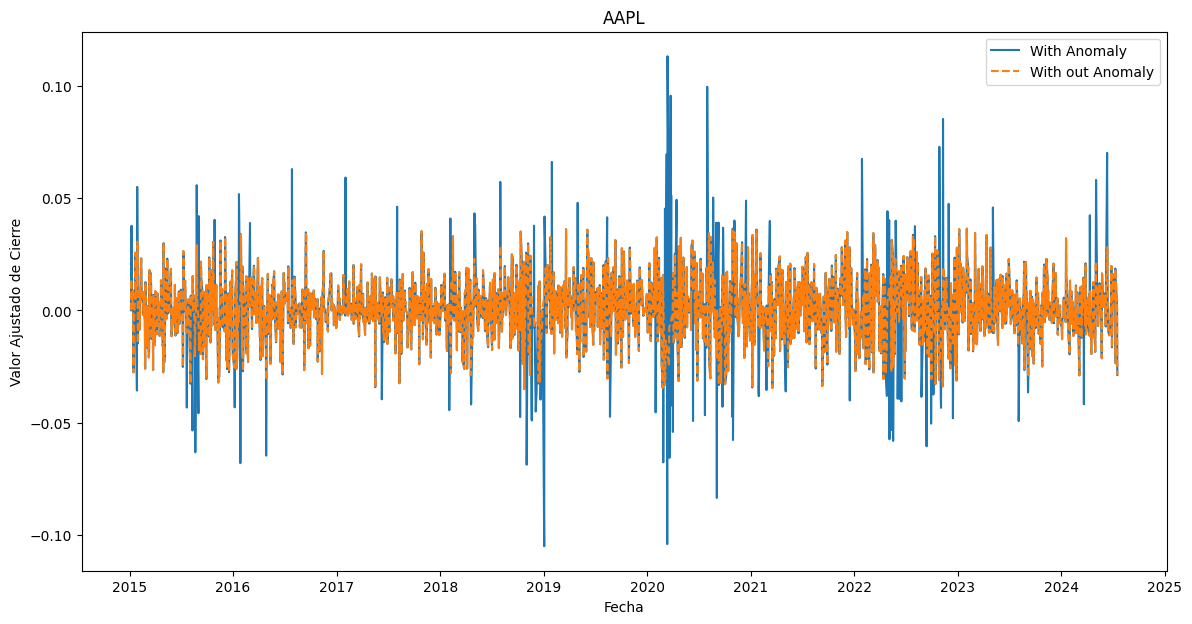

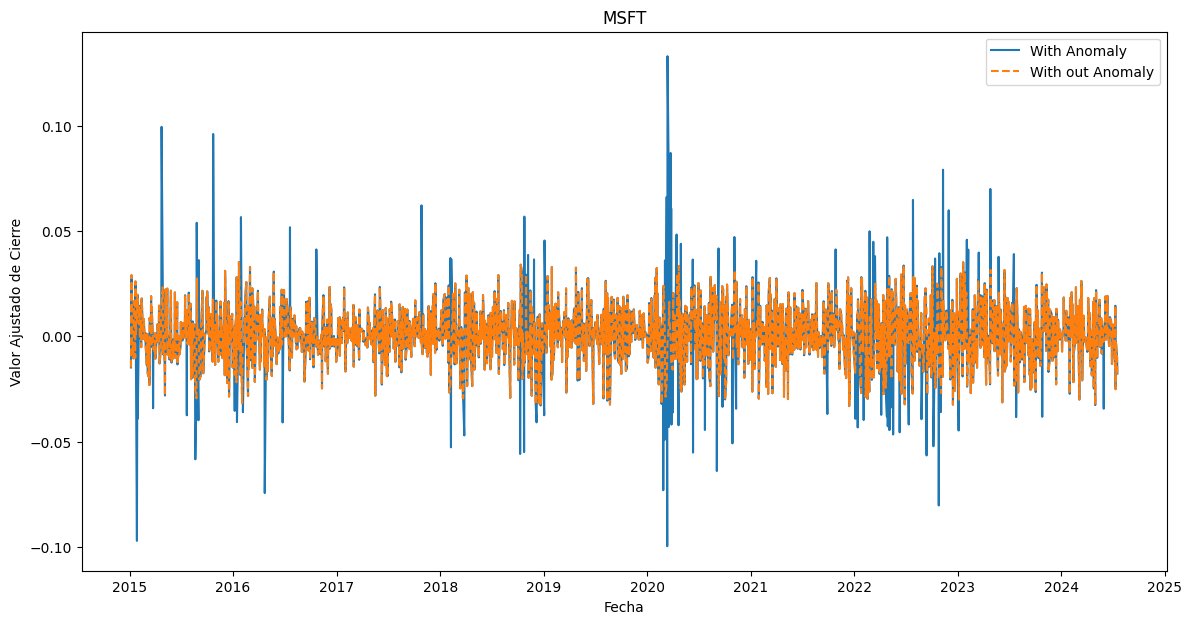

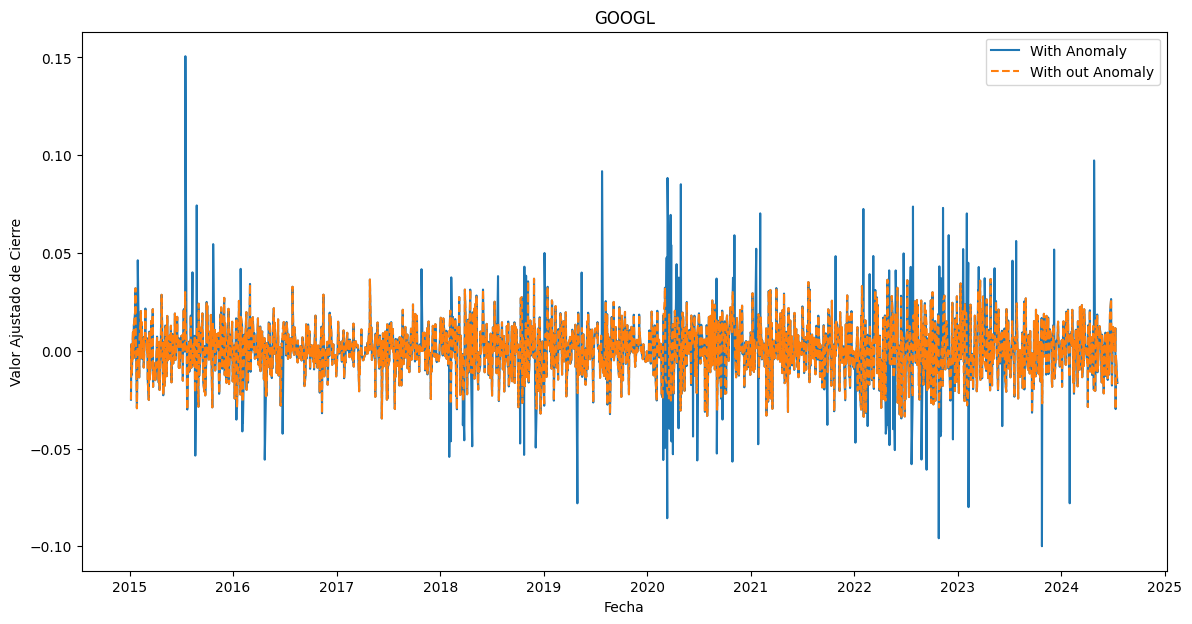

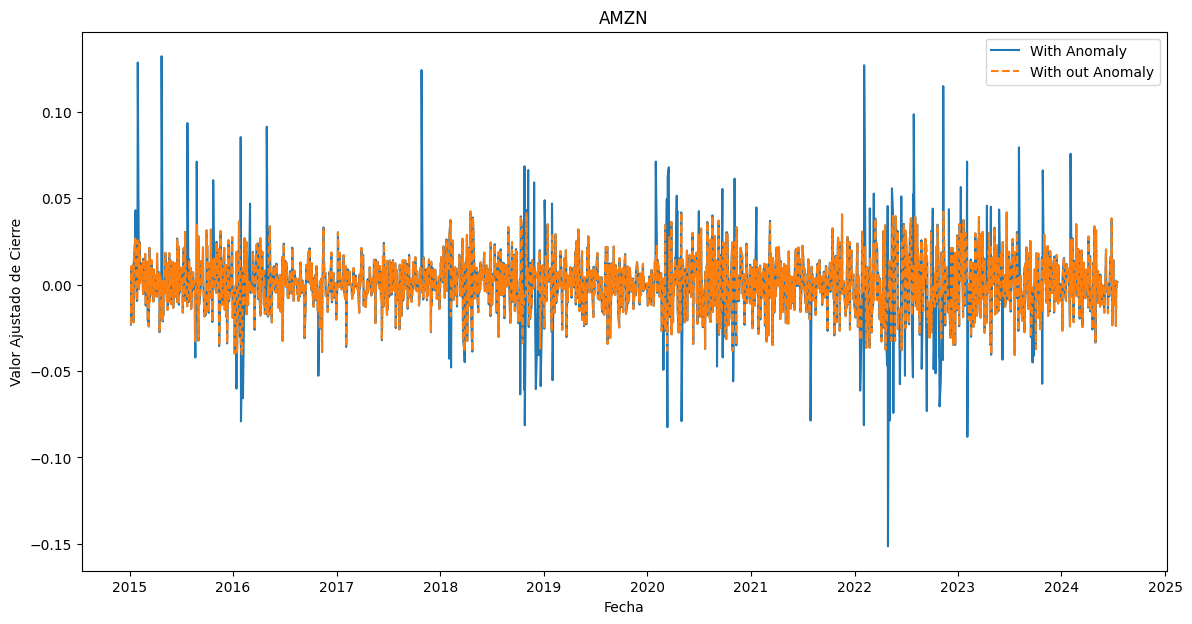

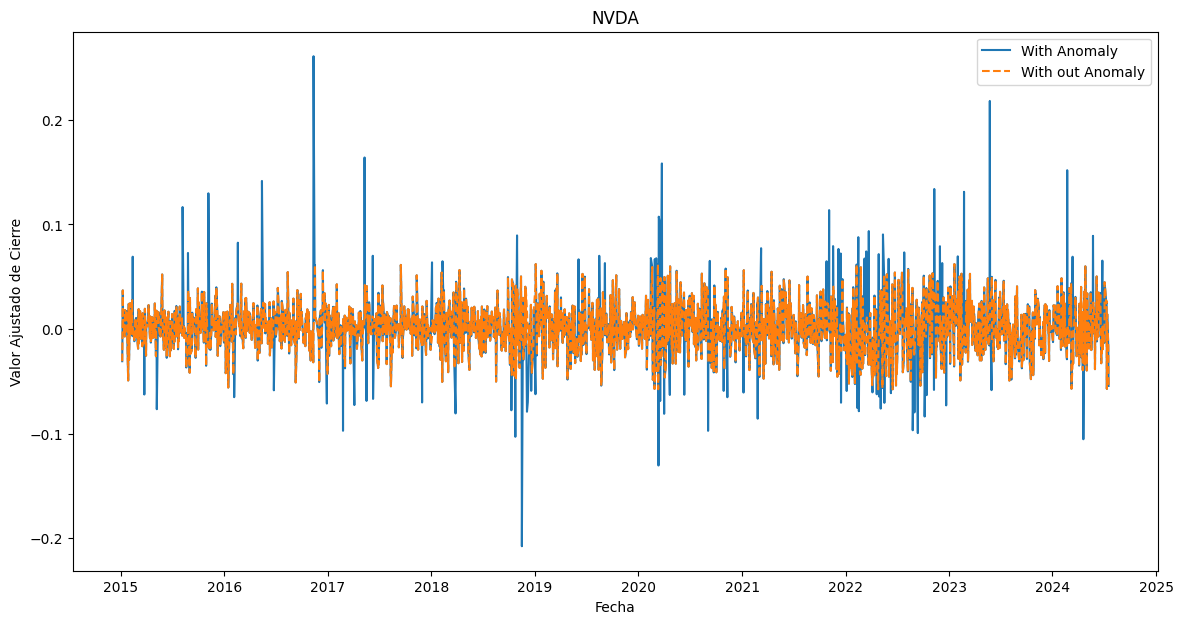

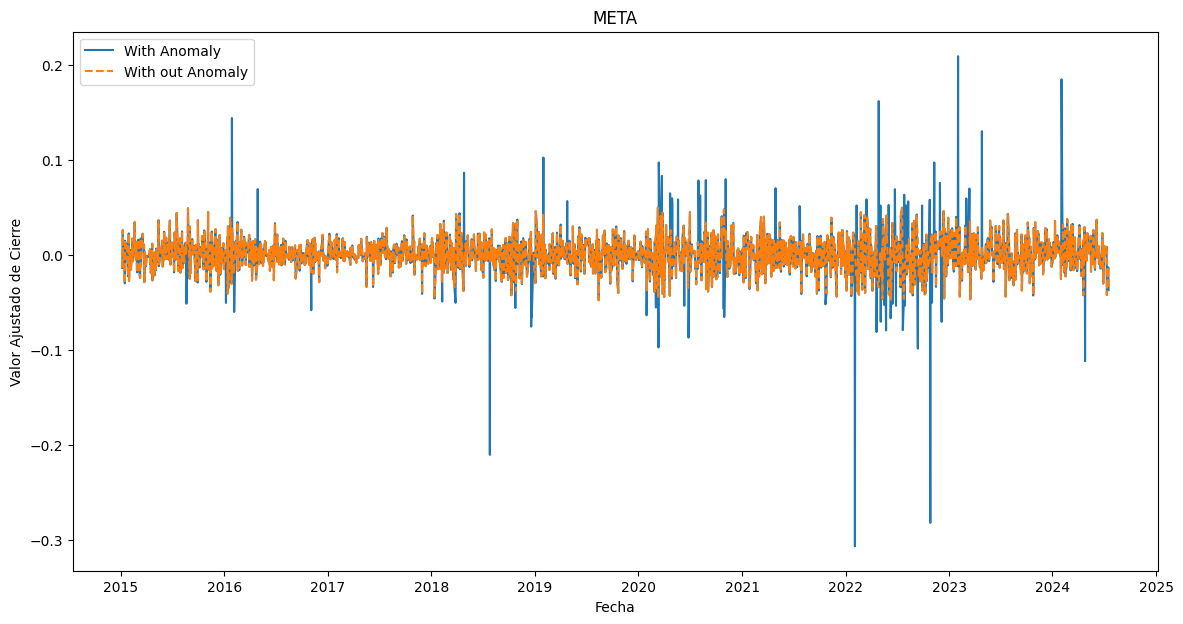

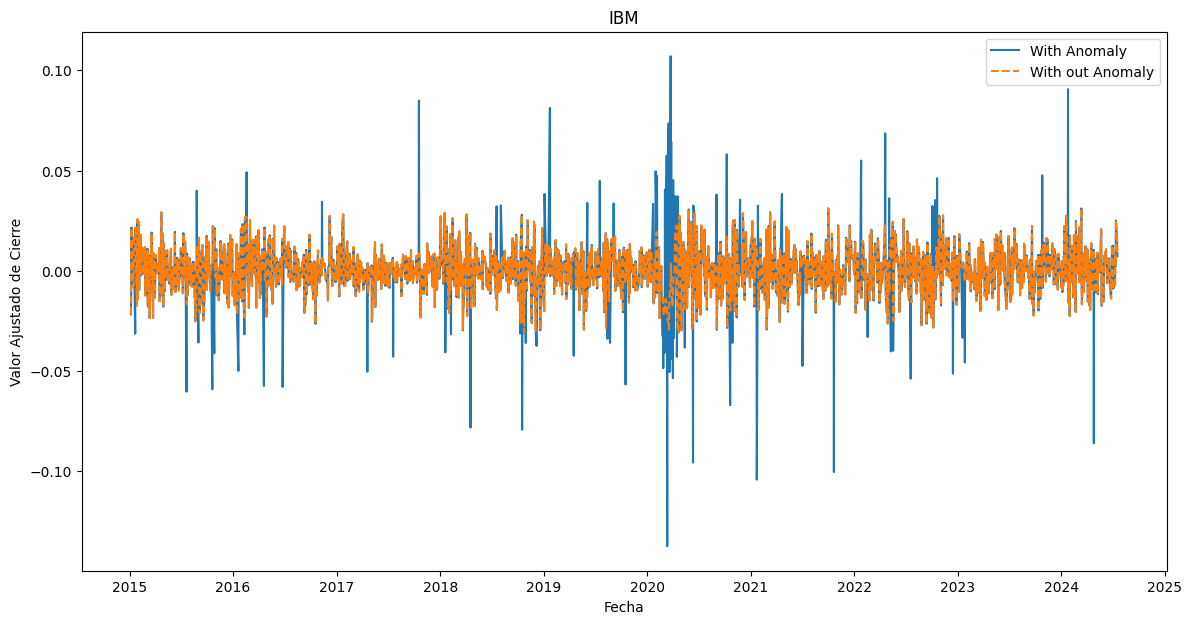

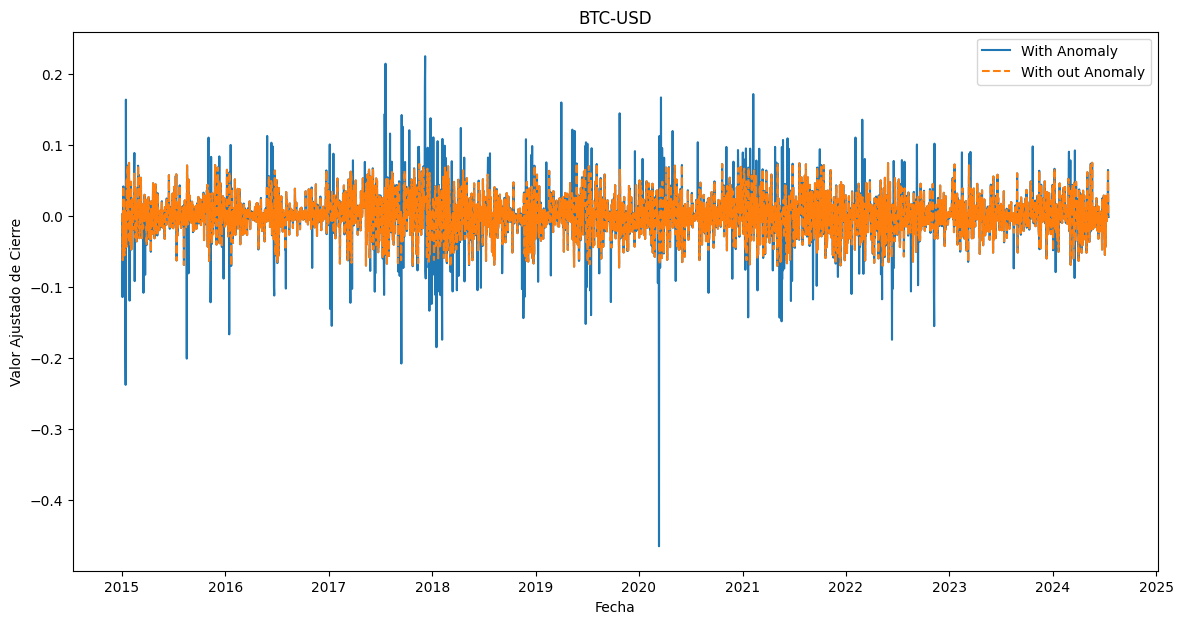

In [6]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()

In [7]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [8]:
season_length = 7 # Define season length as 7 months for daily data
horizon = 28 # Forecast horizon is set to 28 days

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [9]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

In [ ]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=3, step_size=horizon, level=[95])
cv_df.head()

NameError: name 'sf' is not defined

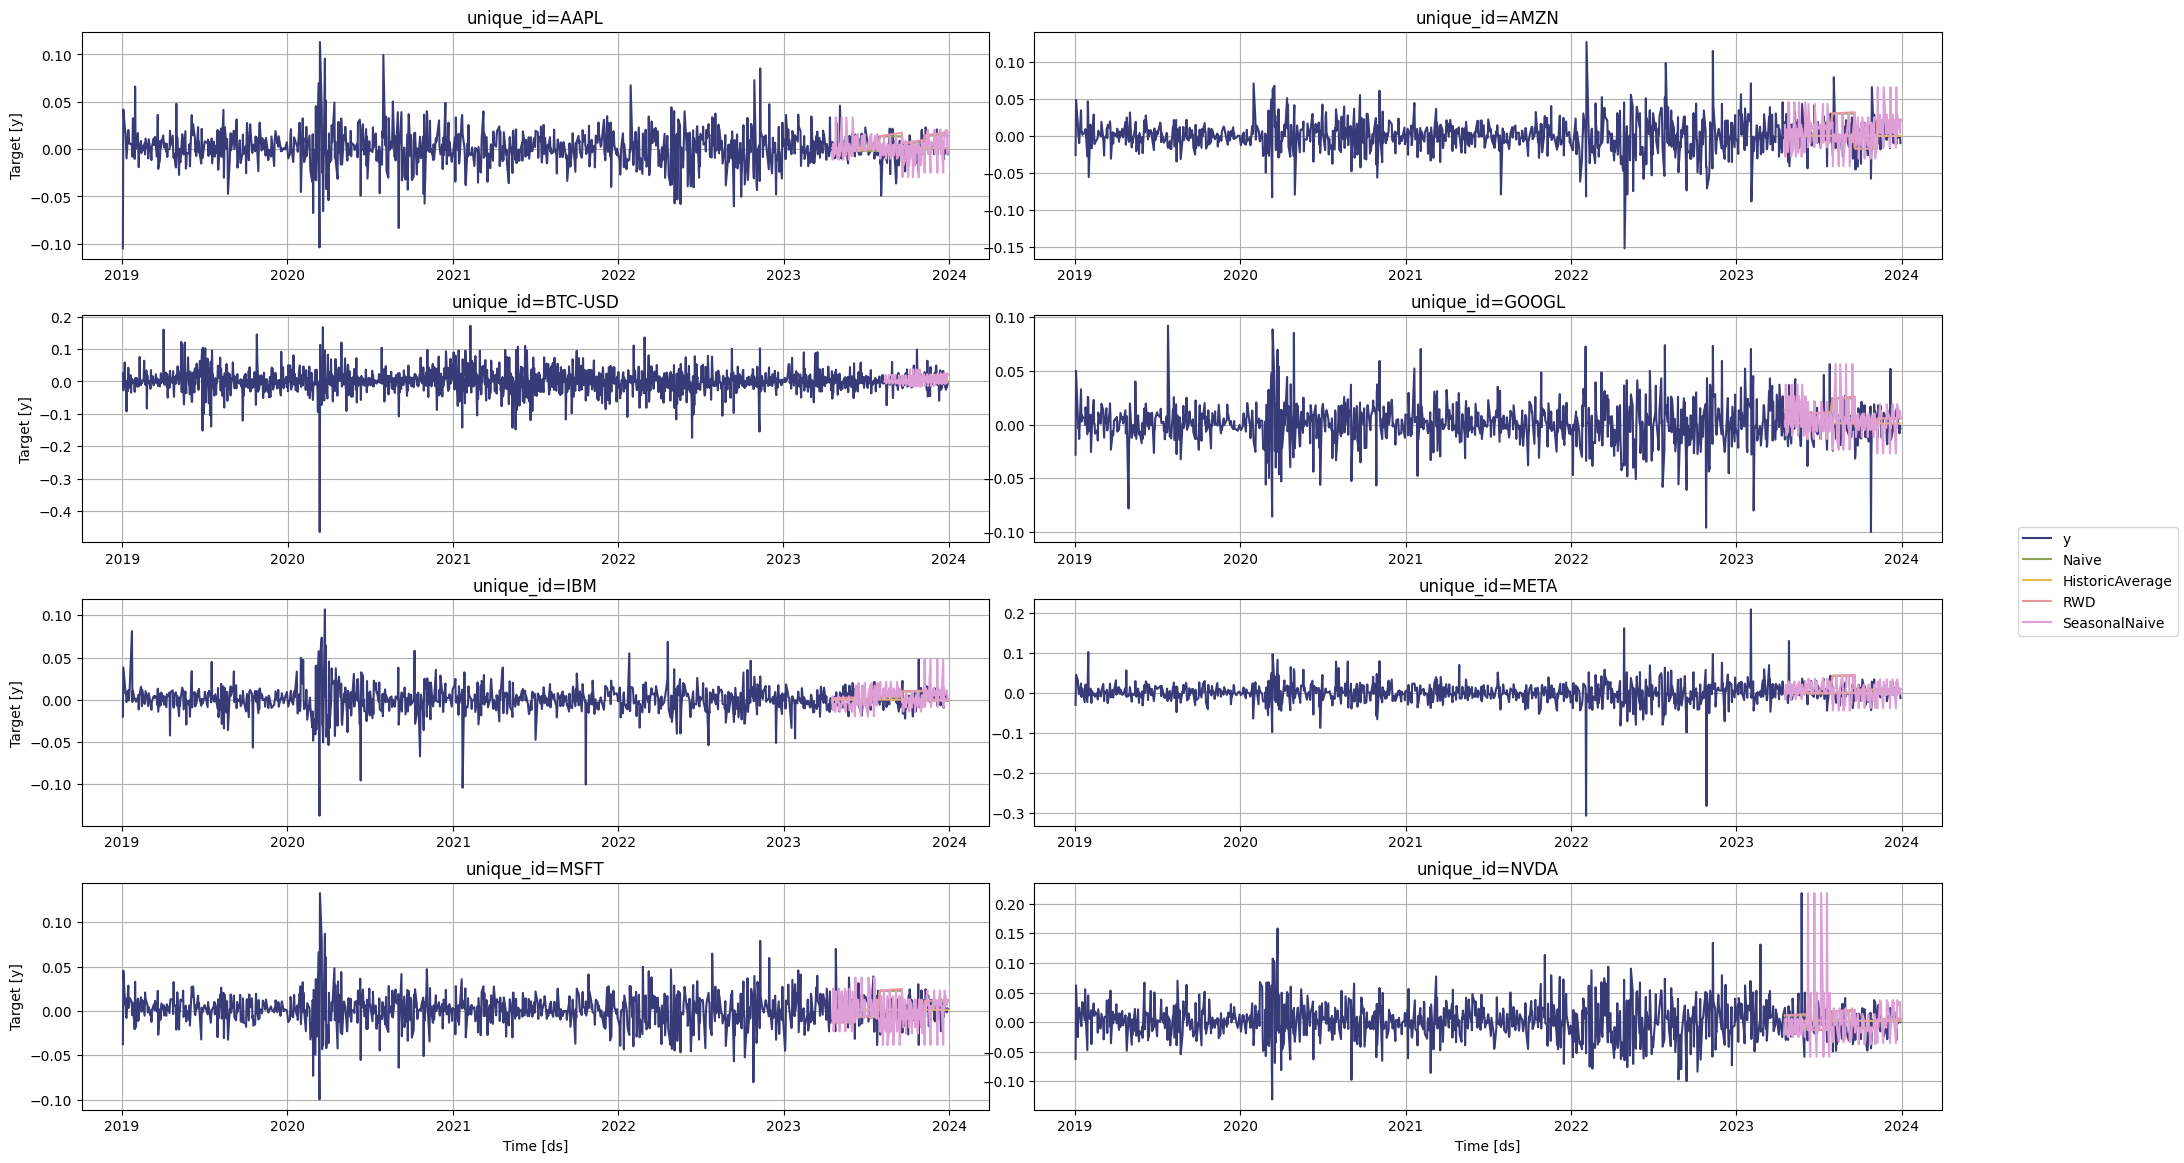

In [ ]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [ ]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [ ]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})


In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-10 10:09:53,795 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a65751789bb342ef22e34a0c7352920b initialized by task ('shuffle-transfer-a65751789bb342ef22e34a0c7352920b', 6) executed on worker tcp://127.0.0.1:50180
2024-07-10 10:09:57,623 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a65751789bb342ef22e34a0c7352920b deactivated due to stimulus 'task-finished-1720598997.618824'


,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive
0,AAPL,2023-04-14,mse,0.000183,0.000159,0.000167,0.000393
1,AAPL,2023-04-14,mae,0.009476,0.008863,0.008839,0.01524
2,AAPL,2023-04-14,smape,164.059967,160.589569,171.559113,158.036606
3,AMZN,2023-06-06,mse,0.000404,0.000346,0.000412,0.000845
4,AMZN,2023-06-06,mae,0.015843,0.013726,0.015985,0.024829


In [ ]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  HistoricAverage         RWD  SeasonalNaive
cutoff     metric                                                        
2023-04-14 mae       0.016536         0.014812    0.016478       0.020489
           mse        0.00068         0.000635    0.000674       0.000947
           smape   153.613861       179.828125  152.404984     147.125519
2023-06-06 mae         0.0152         0.013398    0.015071       0.023841
           mse       0.000399         0.000315    0.000393        0.00168
           smape   155.084152       169.925674  156.706909      144.47644
2023-07-28 mae       0.027226         0.012005    0.028143       0.019374
           mse       0.001077         0.000282    0.001134       0.000661
           smape   157.567871       171.024918  158.418289     138.841354
2023-08-12 mae       0.012882         0.013092    0.012821       0.013905
           mse       0.000501         0.000507      0.0005       0.000449
           smape   177.086945       168.518524  183.120972     157.704697
2023-09-09 mae        0.01057         0.010506     0.01061       0.012932
           mse       0.000209         0.000202    0.000211       0.000288
           smape   184.174652       163.965759   178.40889     162.350983
2023-09-19 mae       0.016737         0.014777    0.016792       0.019863
           mse       0.000466         0.000402    0.000469       0.000625
           smape   148.332199       177.488968  150.255219     152.475937
2023-10-07 mae       0.014431         0.014406    0.014477       0.020215
           mse       0.000567         0.000562     0.00057       0.000948
           smape   183.094894       177.028854  187.626373     132.969666
2023-11-04 mae       0.017319         0.015914    0.017298       0.018279
           mse       0.000541         0.000516     0.00054       0.000484
           smape   136.226196       172.208817  136.580887     152.008469
2023-11-07 mae       0.012098         0.009411    0.012559         0.0176
           mse       0.000232         0.000147    0.000247       0.000535
           smape   133.509109        169.60672  134.386887     139.025757
2023-12-02 mae       0.024559         0.018031    0.024531       0.023599
           mse       0.000871         0.000555     0.00087       0.000768
           smape   134.840393       162.801361  134.835175     163.039001

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

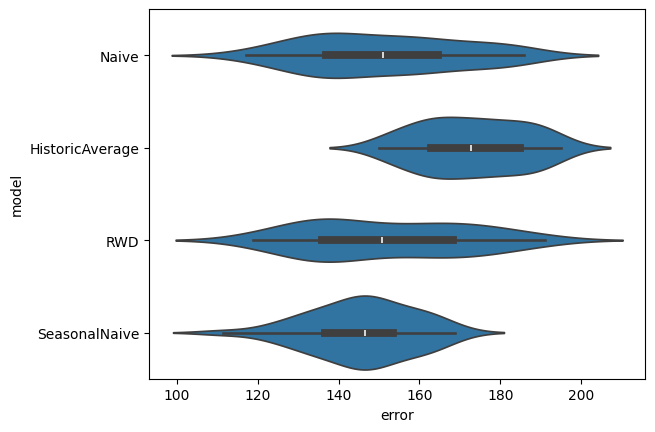

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

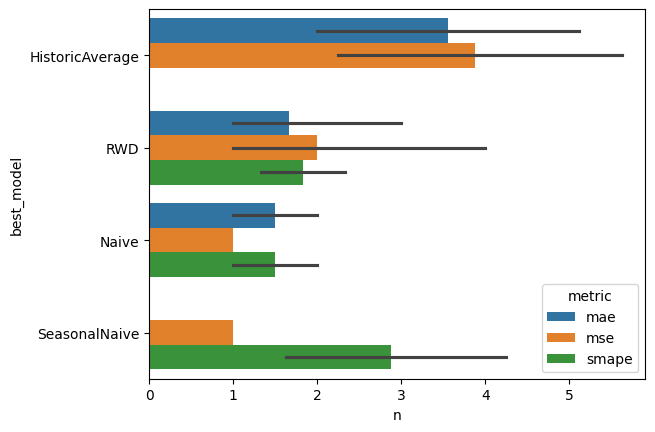

In [ ]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')